In [198]:
## Importing the required libraries

In [199]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [200]:
from keras import regularizers

In [201]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import matplotlib.pyplot as plt
import librosa.display

In [202]:
RAV = "../dataset/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
dir_list[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [203]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: labels, dtype: int64

In [204]:
RAV_df

,labels,source,path
0,male_neutral,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_01/...
1,male_neutral,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_01/...
2,male_neutral,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_01/...
3,male_neutral,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_01/...
4,male_neutral,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_01/...
...,...,...,...
1435,female_surprise,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_24/...
1436,female_surprise,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_24/...
1437,female_surprise,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_24/...
1438,female_surprise,RAVDESS,../dataset/audio_speech_actors_01-24/Actor_24/...


In [205]:
print("Labels: ", RAV_df["labels"].unique())
print()
RAV_df.groupby("labels").count()[["path"]]

Labels:  ['male_neutral' 'male_happy' 'male_sad' 'male_angry' 'male_fear'
 'male_disgust' 'male_surprise' 'female_neutral' 'female_happy'
 'female_sad' 'female_angry' 'female_fear' 'female_disgust'
 'female_surprise']



,path
labels,
female_angry,96
female_disgust,96
female_fear,96
female_happy,96
female_neutral,144
female_sad,96
female_surprise,96
male_angry,96
male_disgust,96


In [206]:
save_path = "../content/data"

train_df, test_df = train_test_split(RAV_df, test_size=0.2, random_state=101, stratify=RAV_df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


## Plotting the audio file's waveform and its spectrogram

In [207]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


## Setting the labels

## Getting the features of audio files using librosa

In [208]:
paths = RAV_df['path']
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(paths):
    #print(index, y)
    #if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
    X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    feature = mfccs
    #[float(i) for i in feature]
    #feature1=feature[:135]
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1        

In [209]:
df[:5]

,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."


In [210]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-58.988811,-58.988811,-60.665466,-60.689583,-59.735569,-60.501480,-60.420517,-59.816250,-60.189262,-60.110905,...,-58.988811,-58.988811,-58.988811,-58.916401,-58.988811,-58.988811,-58.988811,-58.988811,-58.988811,-58.988811
1436,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,...,-38.598328,-38.009247,-40.035809,-39.657108,-40.550026,-43.559956,-45.444458,-46.496017,-46.470703,-47.322212
1437,-56.940815,-56.940815,-56.940815,-56.940815,-56.940815,-56.943363,-57.077030,-56.940815,-56.940815,-57.228634,...,-43.485592,-42.686459,-44.226131,-44.101894,-43.651344,-45.493496,-47.759686,-50.536503,-51.336391,-50.690861
1438,-55.255135,-55.255135,-55.186649,-55.345291,-55.053379,-53.088177,-52.199924,-52.218304,-52.633869,-51.629967,...,-47.927128,-50.145138,-48.712173,-47.603024,-45.205418,-44.438683,-48.720501,-50.850346,-50.327168,-48.915745


df3[:5]

In [211]:
labels = RAV_df['labels']
newdf = pd.concat([df3,labels], axis=1)


In [212]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [213]:
rnewdf[:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,labels
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661,male_neutral
5,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-57.270752,-56.743652,-56.140930,-57.532017,-59.493046,-67.149849,-67.498711,-66.086418,-66.205048,male_neutral
6,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-61.018559,-60.341145,-63.465332,-64.500137,-61.646843,-58.001488,-58.848484,-62.603935,-61.121773,male_neutral
7,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-57.681641,-56.301266,-58.650131,-63.881088,-63.749409,-65.222473,-65.308250,-67.008553,-68.636299,male_neutral
8,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-50.568867,-53.505844,-54.222256,-51.545525,-52.573784,-54.786297,-56.344280,-57.508217,-56.577332,male_neutral
9,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-29.354748,-30.388712,-30.094086,-30.615465,-31.126341,-31.148714,-31.413185,-31.356203,-30.060383,male_neutral


In [214]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,labels
786,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,-68.854813,...,-68.792786,-68.723152,-68.000206,-66.457191,-68.129662,-68.811119,-67.433525,-67.296227,-68.486076,female_neutral
741,-62.691265,-61.921368,-58.112362,-55.378605,-56.545517,-58.246254,-58.498600,-58.577019,-59.843185,-59.149376,...,-56.717537,-58.949966,-57.629890,-59.174885,-58.905422,-57.774433,-63.483849,-65.929726,-64.601265,male_sad
698,-57.419632,-57.696335,-58.593155,-58.173706,-56.816082,-57.052647,-56.534256,-55.248650,-54.070976,-53.961277,...,-50.393684,-50.474960,-51.069885,-52.064430,-54.821354,-55.741508,-54.562801,-53.602413,-53.358292,female_fear
1164,-53.474155,-53.511452,-52.082039,-50.696167,-50.189938,-50.134415,-50.680767,-51.942772,-53.169273,-53.600010,...,-62.197918,-62.197918,-62.198196,-62.179989,-61.918434,-62.197918,-62.197918,-62.197918,-62.197918,female_sad
518,-60.089787,-61.186764,-60.369534,-60.131462,-59.682110,-59.164402,-58.312378,-60.574406,-65.208549,-70.483025,...,-56.409870,-60.552391,-62.478554,-61.613541,-56.192425,-54.207466,-55.882080,-55.511684,-58.704964,male_fear
1105,-55.102558,-56.048286,-58.384499,-61.521549,-64.581596,-64.264366,-63.681618,-61.965195,-63.487453,-64.640678,...,-51.864803,-52.473709,-51.908848,-54.379391,-53.660034,-53.956100,-52.871704,-51.789467,-52.396381,male_sad
1043,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,-65.210434,...,-52.671288,-53.739876,-56.870102,-58.528603,-61.192078,-57.778610,-58.670589,-62.437386,-65.043129,female_sad
1376,-51.901733,-51.953976,-51.834225,-51.816795,-52.076111,-52.105648,-51.473190,-50.890198,-50.660343,-51.521011,...,-53.263386,-53.263386,-53.226444,-52.401306,-52.240902,-51.482033,-52.637375,-52.970016,-53.263386,male_surprise
1149,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,-79.454170,...,-37.341831,-37.588856,-37.900288,-37.453312,-37.783318,-38.713345,-39.685894,-38.186150,-35.537971,female_neutral
214,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,-43.612679,...,-42.085365,-42.376163,-43.340157,-42.947365,-43.227009,-43.231194,-44.128220,-43.662796,-42.890789,female_angry


In [215]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [216]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [217]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,labels
102,-51.358871,-51.638977,-51.997269,-51.910355,-51.692856,-51.664940,-51.767826,-51.822567,-52.103909,-52.059486,...,-49.337711,-50.789944,-50.442051,-51.949978,-50.959999,-50.434090,-50.234821,-51.110268,-51.266232,female_fear
260,-65.012177,-62.332249,-65.145363,-74.183067,-77.810989,-77.903465,-78.839149,-77.973900,-69.871590,-62.527519,...,-62.252056,-65.876846,-67.579140,-61.824150,-62.076839,-65.980927,-67.948471,-71.522568,-76.508499,male_sad
419,-57.254601,-57.254601,-57.254601,-57.254601,-56.735863,-56.598503,-57.254601,-57.254601,-57.254601,-57.254601,...,-45.593632,-46.054928,-45.883911,-46.726562,-46.430088,-47.236164,-49.231026,-47.199142,-46.399151,male_surprise
1258,-55.477638,-55.023621,-53.268936,-52.932861,-52.404671,-52.209049,-52.069626,-53.098457,-53.062256,-52.698025,...,-54.063232,-54.588745,-55.305439,-54.877872,-54.315720,-54.058735,-53.360317,-52.790226,-53.169960,male_surprise
1080,-63.393501,-60.851528,-58.837444,-59.027035,-58.936684,-55.688091,-53.725571,-53.267906,-52.348530,-51.438309,...,-58.230343,-59.048733,-62.915852,-62.098450,-59.426155,-58.405361,-56.096516,-56.379257,-58.569496,male_neutral
798,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,-47.939163,...,-39.217300,-41.336365,-43.327106,-44.894978,-46.341667,-46.351433,-46.122211,-45.831158,-45.531868,female_happy
1038,-49.566441,-47.824402,-46.220272,-45.217979,-43.194168,-42.643661,-43.485649,-44.540710,-45.943306,-47.248997,...,-41.133945,-41.743568,-40.540928,-42.072590,-45.595589,-48.221561,-48.224663,-48.336758,-48.210957,female_happy
685,-46.456722,-47.024208,-46.142891,-46.262917,-46.480350,-46.620781,-47.260395,-46.667107,-47.757442,-46.490688,...,-45.584675,-43.598022,-46.936813,-47.840897,-48.035347,-47.782524,-45.367897,-45.400932,-47.511482,female_sad
974,-53.141987,-52.674992,-50.214226,-50.819004,-54.603825,-52.255264,-50.683800,-52.724796,-49.598228,-51.657570,...,-47.976353,-47.613281,-48.414055,-49.194748,-50.277706,-52.465252,-54.078613,-56.517986,-57.023308,male_happy
204,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,-54.384609,...,-54.320442,-54.153461,-54.013290,-52.559669,-52.440292,-52.519524,-53.176575,-52.175941,-52.257362,female_sad


In [218]:
trainfeatures = train.iloc[:, :-1]

In [219]:
trainlabel = train.iloc[:, -1:]

In [220]:
testfeatures = test.iloc[:, :-1]

In [221]:
testlabel = test.iloc[:, -1:]

In [222]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\colot\anaconda3\envs\cz4042\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [223]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [224]:
X_train.shape

(1151, 216)

## Changing dimension for CNN model

In [225]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [231]:
from tensorflow.keras import optimizers
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [232]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_55 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_56 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 27, 128)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 27, 128)         

In [233]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [234]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

### Removed the whole training part for avoiding unnecessary long epochs list

In [235]:
cnnhistory=model.fit(x_traincnn, 
                     y_train, 
                     batch_size=16, 
                     epochs=700, 
                     callbacks = [callback],
                     validation_data=(x_testcnn, y_test))

Epoch 1/700
72/72 [==============================] - 5s 59ms/step - loss: 2.9955 - accuracy: 0.0791 - val_loss: 2.6412 - val_accuracy: 0.1280
Epoch 2/700
72/72 [==============================] - 4s 58ms/step - loss: 2.5920 - accuracy: 0.1260 - val_loss: 2.5697 - val_accuracy: 0.1211
Epoch 3/700
72/72 [==============================] - 4s 56ms/step - loss: 2.5541 - accuracy: 0.1390 - val_loss: 2.5311 - val_accuracy: 0.1419
Epoch 4/700
72/72 [==============================] - 4s 57ms/step - loss: 2.5245 - accuracy: 0.1477 - val_loss: 2.5033 - val_accuracy: 0.1626
Epoch 5/700
72/72 [==============================] - 4s 61ms/step - loss: 2.4991 - accuracy: 0.1529 - val_loss: 2.4886 - val_accuracy: 0.1869
Epoch 6/700
72/72 [==============================] - 4s 62ms/step - loss: 2.4725 - accuracy: 0.1668 - val_loss: 2.4665 - val_accuracy: 0.1661
Epoch 7/700
72/72 [==============================] - 4s 62ms/step - loss: 2.4519 - accuracy: 0.1807 - val_loss: 2.4407 - val_accuracy: 0.2111
Epoch 

72/72 [==============================] - 4s 62ms/step - loss: 1.7481 - accuracy: 0.3979 - val_loss: 1.9662 - val_accuracy: 0.3114
Epoch 59/700
72/72 [==============================] - 4s 59ms/step - loss: 1.7448 - accuracy: 0.3858 - val_loss: 1.9245 - val_accuracy: 0.3599
Epoch 60/700
72/72 [==============================] - 4s 60ms/step - loss: 1.7439 - accuracy: 0.4023 - val_loss: 1.9057 - val_accuracy: 0.3287
Epoch 61/700
72/72 [==============================] - 4s 59ms/step - loss: 1.7375 - accuracy: 0.3892 - val_loss: 1.9213 - val_accuracy: 0.3426
Epoch 62/700
72/72 [==============================] - 4s 58ms/step - loss: 1.7267 - accuracy: 0.4101 - val_loss: 1.9514 - val_accuracy: 0.3080
Epoch 63/700
72/72 [==============================] - 5s 63ms/step - loss: 1.7211 - accuracy: 0.4040 - val_loss: 1.9245 - val_accuracy: 0.3391
Epoch 64/700
72/72 [==============================] - 5s 65ms/step - loss: 1.7121 - accuracy: 0.4066 - val_loss: 1.9112 - val_accuracy: 0.3391
Epoch 65/700

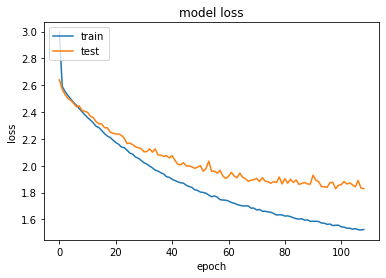

In [236]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [237]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\colot\OneDrive - Nanyang Technological University\Backup\Y3S1\CZ4042 NNDL\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model.h5 


In [238]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [239]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 34.26%


## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
preds

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
data, sampling_rate = librosa.load('output10.wav')

In [ ]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
livepreds

In [ ]:
livepreds1=livepreds.argmax(axis=1)

In [ ]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions